# 1D benchmark

In this notebook, the result of 1D logitudinal CSR field of a beam is benchmarked with the analytic solution from Murphy et al. (1997) paper. The input deck used is input/test_beam_remap.py. The field is obtained by taking the gradient either through numpy's finite difference gradient or through Portage's least squares estimate. It is recommended to use enough simulation particles (e.g., 1e5) to reduce the noise in the field. The simulaton can be run with various choices of wavelet distribution, kernel and filter, please see the arguments of gen_test_wavelets function.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import signal
from numpy import linalg 

import CosyrAnalyze 
import seaborn as sns

# plot setting 
mpl.rcParams['font.size'] = 12
mpl.rcParams["mathtext.default"] = "it"
mpl.rcParams['mathtext.fontset'] = 'cm'

#sns.plotting_context("poster")
sns.set_style("white")
#sns.axes_style({'font.family':'serif', 'font.serif':'Arial'})
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Latin Modern Roman', "xtick.direction": "in","ytick.direction": "in"})
#print("Using following seaborn style:")
#print(sns.axes_style())

# Cosyr result analysis

## Load wavefronts and mesh

In [2]:
gamma = 1000
nalpha = 1001
nchi = 3
step = 1
particle_id = 0
ndirs = 0
R_bend = 1.0 # meter
beam_charge = 0.01*1e-9  # Coulomb
N = beam_charge/1.6e-19  # number of real particles in the beam
axis_range = 600000.0
sigma = 200.0e-6/R_bend * gamma**3.0 / 6.0

beta = np.sqrt(1.0-gamma**(-2.0))

In [3]:
output_path = "../build/test_beam_remap_g1000_adaptive/"
cosyr_1D_result=CosyrAnalyze.CosyrAnalyze(gamma, output_path, charge=beam_charge, pid=particle_id, step = step, load_data_all=0, wf_xy_rotate=0, )
cosyr_1D_result.load_wavefronts()
cosyr_1D_result.load_cmesh()

setting gamma to  1000
setting data_dir to  ../build/test_beam_remap_g1000_adaptive/
setting charge to  1.0000000000000001e-11
setting R_bend to  1.0
setting pid to  0
setting step to  1
setting dt to  0.0001
setting traj_type to  2
setting load_data_all to  0
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting p_beam to  None
setting self to  <CosyrAnalyze.CosyrAnalyze object at 0x1321e3130>
[[6.00000000e-07 2.00000000e-04]
 [6.00000000e-07 2.00000000e-04]
 [6.00000000e-07 2.00000000e-04]
 ...
 [8.89529131e-07 2.00000000e-04]
 [8.89529131e-07 2.00000000e-04]
 [8.89529131e-07 2.00000000e-04]]


In [4]:
a = cosyr_1D_result.cmesh_fld1.reshape([-1,nchi]).T[1,:]/N
print(a.shape[0])

mesh_potential=cosyr_1D_result.cmesh_fld1.reshape([-1,nchi]).T[1,:]/N

mesh_fld=gamma**3.0*np.gradient(mesh_potential, axis_range/(mesh_potential.shape[0]-1))
mesh_fld_sm=signal.savgol_filter(mesh_fld, 51, 3)
mesh_fld_remap=cosyr_1D_result.cmesh_fld1_dx.reshape([-1,nchi]).T[1,:]/N
mesh_fld_remap_sm=signal.savgol_filter(mesh_fld_remap, 51, 3)
alpha_axis = np.linspace(-axis_range/2.0, axis_range/2.0, mesh_potential.shape[0])


1001


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


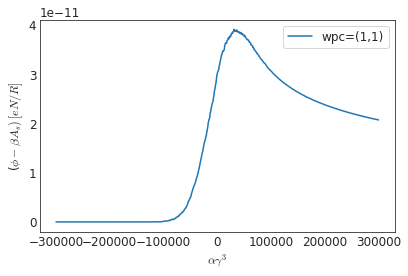

In [5]:
plt.figure()
plt.plot(alpha_axis, mesh_potential, label="wpc=(1,1)")
plt.xlabel(r"$\alpha \gamma^{3}$")
plt.ylabel(r"($\phi - \beta A_s) \, [eN/R]$")
plt.legend()
plt.tight_layout()

## Comparison with analytic result from parabolic cylinder function (for Gaussian beam only)

### Generate analytic result

In [6]:
# Note: scipy parabolic cylinder function sometimes leads to kernel crash, especially if axis range is too large
x = alpha_axis/sigma
parabolic_cylinder_func = scipy.special.pbdv(1.0/3.0, -x) 
temp=parabolic_cylinder_func[0].copy()
analytic_beam_fld = temp*np.exp(-x**2.0/4.0)*scipy.special.gamma(2.0/3.0) 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


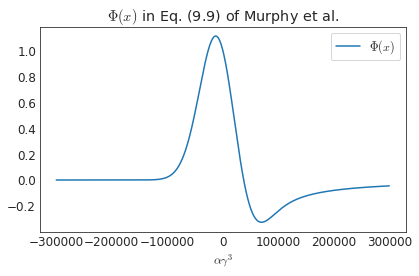

In [7]:
plt.figure()
plt.clf()
plt.plot(alpha_axis, analytic_beam_fld, label=r"$\Phi(x)$")
plt.xlabel(r"$\alpha \gamma^{3}$")
plt.title(r"$\Phi(x)$ in Eq. (9.9) of Murphy et al.")
plt.legend(loc="upper right")
plt.tight_layout()

In [8]:
# Eq. (9.8) in Murphy 1997 paper, in unit of e*gamma^4/R^2, averaged for each particle (i.e., beam of chagre e)
analytic_beam_fld *= np.sqrt(2.0/np.pi)/(3.0*(sigma/gamma**3.0/R_bend)**4.0)**(1.0/3.0)/gamma**4.0

### Plot comparison

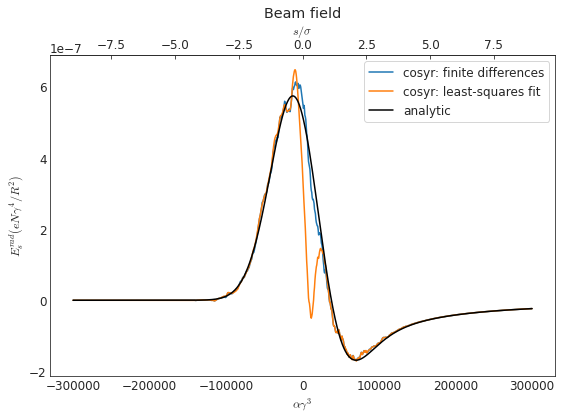

In [9]:
def alpha2sigma(x):
    global sigma
    return x/sigma


def sigma2alpha(x):
    global sigma
    return x * sigma

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(alpha_axis,mesh_fld_sm, label="cosyr: finite differences")
ax.plot(alpha_axis,mesh_fld_remap_sm, label="cosyr: least-squares fit")
ax.plot(alpha_axis, analytic_beam_fld, "k-", label="analytic")

secax = ax.secondary_xaxis('top', functions=(alpha2sigma, sigma2alpha))
secax.set_xlabel(r'$s/\sigma$')

ax.set_xlabel(r"$\alpha \gamma^{3}$")
ax.set_ylabel(r"$E_{s}^{rad} (e N\gamma^4/R^2)$")
ax.set_title("Beam field")
plt.legend(loc="upper right")
plt.tight_layout()

In [10]:
# L2 norm, note that error at the front/back sides of the simulation box is due to limited wavelet coverage in the box.
print("cosyr: finite differences: L2 norm =", linalg.norm(analytic_beam_fld-mesh_fld_sm))
print("cosyr: least-squares fit:  L2 norm =", linalg.norm(analytic_beam_fld-mesh_fld_remap_sm))

cosyr: finite differences: L2 norm = 4.5668000916472373e-07
cosyr: least-squares fit:  L2 norm = 1.963971869172473e-06


In [11]:
# L2 norm for the result for -6<s/sigma<6, excluding the very front/back 
start_idx = int(nalpha/18.0*3.0)
end_idx = nalpha - start_idx
print("cosyr: finite differences: L2 norm =", linalg.norm(analytic_beam_fld[start_idx:end_idx]-mesh_fld_sm[start_idx:end_idx]))
print("cosyr: least-squares fit:  L2 norm =", linalg.norm(analytic_beam_fld[start_idx:end_idx]-mesh_fld_remap_sm[start_idx:end_idx]))

cosyr: finite differences: L2 norm = 4.566758693524553e-07
cosyr: least-squares fit:  L2 norm = 1.963970923845615e-06


1001
1001
setting gamma to  1000
setting data_dir to  ../build/test_beam_remap_g1000/
setting charge to  1.0000000000000001e-11
setting R_bend to  1.0
setting pid to  0
setting step to  1
setting dt to  0.0001
setting traj_type to  2
setting load_data_all to  0
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting p_beam to  None
setting self to  <CosyrAnalyze.CosyrAnalyze object at 0x1344f4490>
[[6.e-07 2.e-04]
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]
 ...
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]]
setting gamma to  1000
setting data_dir to  ../build/test_beam_remap_g1000_uniform/
setting charge to  1.0000000000000001e-11
setting R_bend to  1.0
setting pid to  0
setting step to  1
setting dt to  0.0001
setting traj_type to  2
setting load_data_all to  0
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting p_beam to  None
setting self to  <CosyrAnalyze.CosyrAnalyze object at 0x1321e3ee0>
[[6.e-07 2.e-04]
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]
 ...
 [6.e-07 2.e-04]
 [6.e-07 

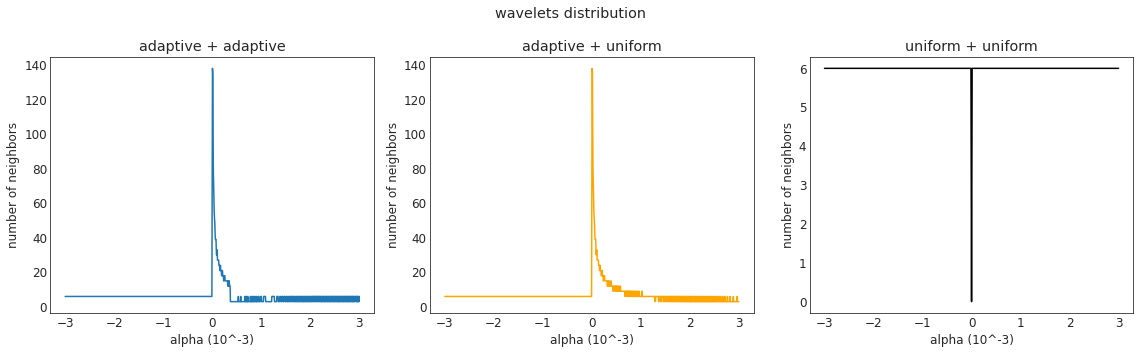

In [12]:
# plot histogram of wavelets with respect to mesh points coordinates
x = cosyr_1D_result.cmesh_x.reshape([-1,nchi]).T[1,:] * (10**4)
y = cosyr_1D_result.cmesh_wavelet_distrib.reshape([-1,nchi]).T[1,:]
print(x.shape[0])
print(y.shape[0])

adapt_unif_result=CosyrAnalyze.CosyrAnalyze(gamma, "../build/test_beam_remap_g1000/", charge=beam_charge, pid=particle_id, step = step, load_data_all=0, wf_xy_rotate=0, )
adapt_unif_result.load_wavefronts()
adapt_unif_result.load_cmesh()
y_prim = adapt_unif_result.cmesh_wavelet_distrib.reshape([-1,nchi]).T[1,:]

unif_unif_result=CosyrAnalyze.CosyrAnalyze(gamma, "../build/test_beam_remap_g1000_uniform/", charge=beam_charge, pid=particle_id, step = step, load_data_all=0, wf_xy_rotate=0, )
unif_unif_result.load_wavefronts()
unif_unif_result.load_cmesh()
y_sec = unif_unif_result.cmesh_wavelet_distrib.reshape([-1,nchi]).T[1,:]


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
ax1.plot(x,y)
ax2.plot(x,y_prim, color="orange")
ax3.plot(x,y_sec, "k-")

ax1.set_title("adaptive + adaptive")
ax2.set_title("adaptive + uniform")
ax3.set_title("uniform + uniform")

ax1.set(xlabel="alpha (10^-3)")
ax2.set(xlabel="alpha (10^-3)")
ax3.set(xlabel="alpha (10^-3)")
ax1.set(ylabel="number of neighbors")
ax2.set(ylabel="number of neighbors")
ax3.set(ylabel="number of neighbors")
# ax1.legend(loc="upper right")
# ax2.legend(loc="upper right")
# ax3.legend(loc="lower right")

fig.suptitle("wavelets distribution")
fig.tight_layout()

adaptive wavelets, adaptive support:
- min:  3
- max:  138
- mean:  6.7732267732267735
- dev:  8.998252826165693


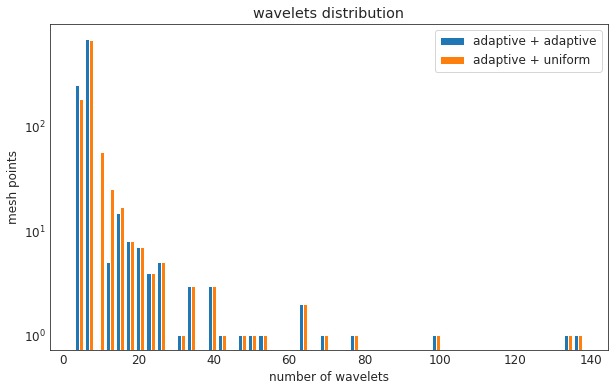

In [13]:
plt.figure(figsize=(10,6))
plt.hist([y, y_prim], bins=50, log=True, label=["adaptive + adaptive", "adaptive + uniform"])
plt.xlabel("number of wavelets")
plt.ylabel("mesh points")
plt.title("wavelets distribution")
plt.legend(loc="upper right")
print("adaptive wavelets, adaptive support:")
print("- min: ", np.min(y))
print("- max: ", np.max(y))
print("- mean: ", np.mean(y))
print("- dev: ", np.std(y))

1001
1001
setting gamma to  1000
setting data_dir to  ../build/test_beam_remap_g1000/
setting charge to  1.0000000000000001e-11
setting R_bend to  1.0
setting pid to  0
setting step to  1
setting dt to  0.0001
setting traj_type to  2
setting load_data_all to  0
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting p_beam to  None
setting self to  <CosyrAnalyze.CosyrAnalyze object at 0x1347b0df0>
[[6.e-07 2.e-04]
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]
 ...
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]]
setting gamma to  1000
setting data_dir to  ../build/test_beam_remap_g1000_uniform/
setting charge to  1.0000000000000001e-11
setting R_bend to  1.0
setting pid to  0
setting step to  1
setting dt to  0.0001
setting traj_type to  2
setting load_data_all to  0
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting p_beam to  None
setting self to  <CosyrAnalyze.CosyrAnalyze object at 0x134432c10>
[[6.e-07 2.e-04]
 [6.e-07 2.e-04]
 [6.e-07 2.e-04]
 ...
 [6.e-07 2.e-04]
 [6.e-07 

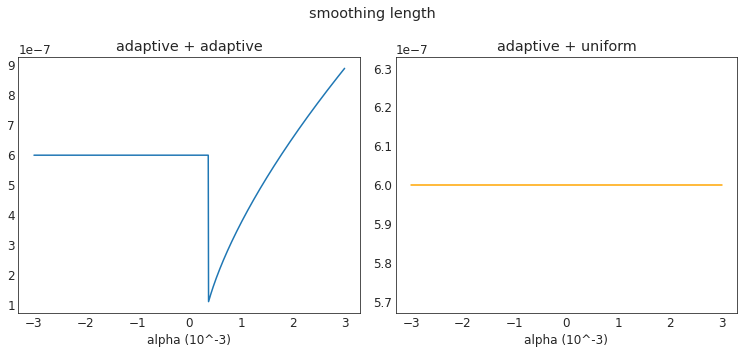

In [15]:
x = cosyr_1D_result.cmesh_x.reshape([-1,nchi]).T[1,:] * (10**4)
y = cosyr_1D_result.cmesh_smoothing_x.reshape([-1,nchi]).T[1,:]
print(x.shape[0])
print(y.shape[0])

adapt_unif_result=CosyrAnalyze.CosyrAnalyze(gamma, "../build/test_beam_remap_g1000/", charge=beam_charge, pid=particle_id, step = step, load_data_all=0, wf_xy_rotate=0, )
adapt_unif_result.load_wavefronts()
adapt_unif_result.load_cmesh()
y_prim = adapt_unif_result.cmesh_smoothing_x.reshape([-1,nchi]).T[1,:]

unif_unif_result=CosyrAnalyze.CosyrAnalyze(gamma, "../build/test_beam_remap_g1000_uniform/", charge=beam_charge, pid=particle_id, step = step, load_data_all=0, wf_xy_rotate=0, )
unif_unif_result.load_wavefronts()
unif_unif_result.load_cmesh()
y_sec = unif_unif_result.cmesh_smoothing_x.reshape([-1,nchi]).T[1,:]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5,5))
ax1.plot(x,y)
ax2.plot(x,y_prim, color="orange")

ax1.set_title("adaptive")
ax2.set_title("uniform")

ax1.set(xlabel="alpha (10^-3)")
ax2.set(xlabel="alpha (10^-3)")

fig.suptitle("smoothing length")
fig.tight_layout()